In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine

In [2]:
data = load_wine()
wine_df = pd.DataFrame(data=np.c_[data['data'], data['target']], columns= data['feature_names'] + ['target'])

In [3]:
wine_df.target = np.round(wine_df.target/2)

In [4]:
wine_df.target = wine_df.target.astype(int)

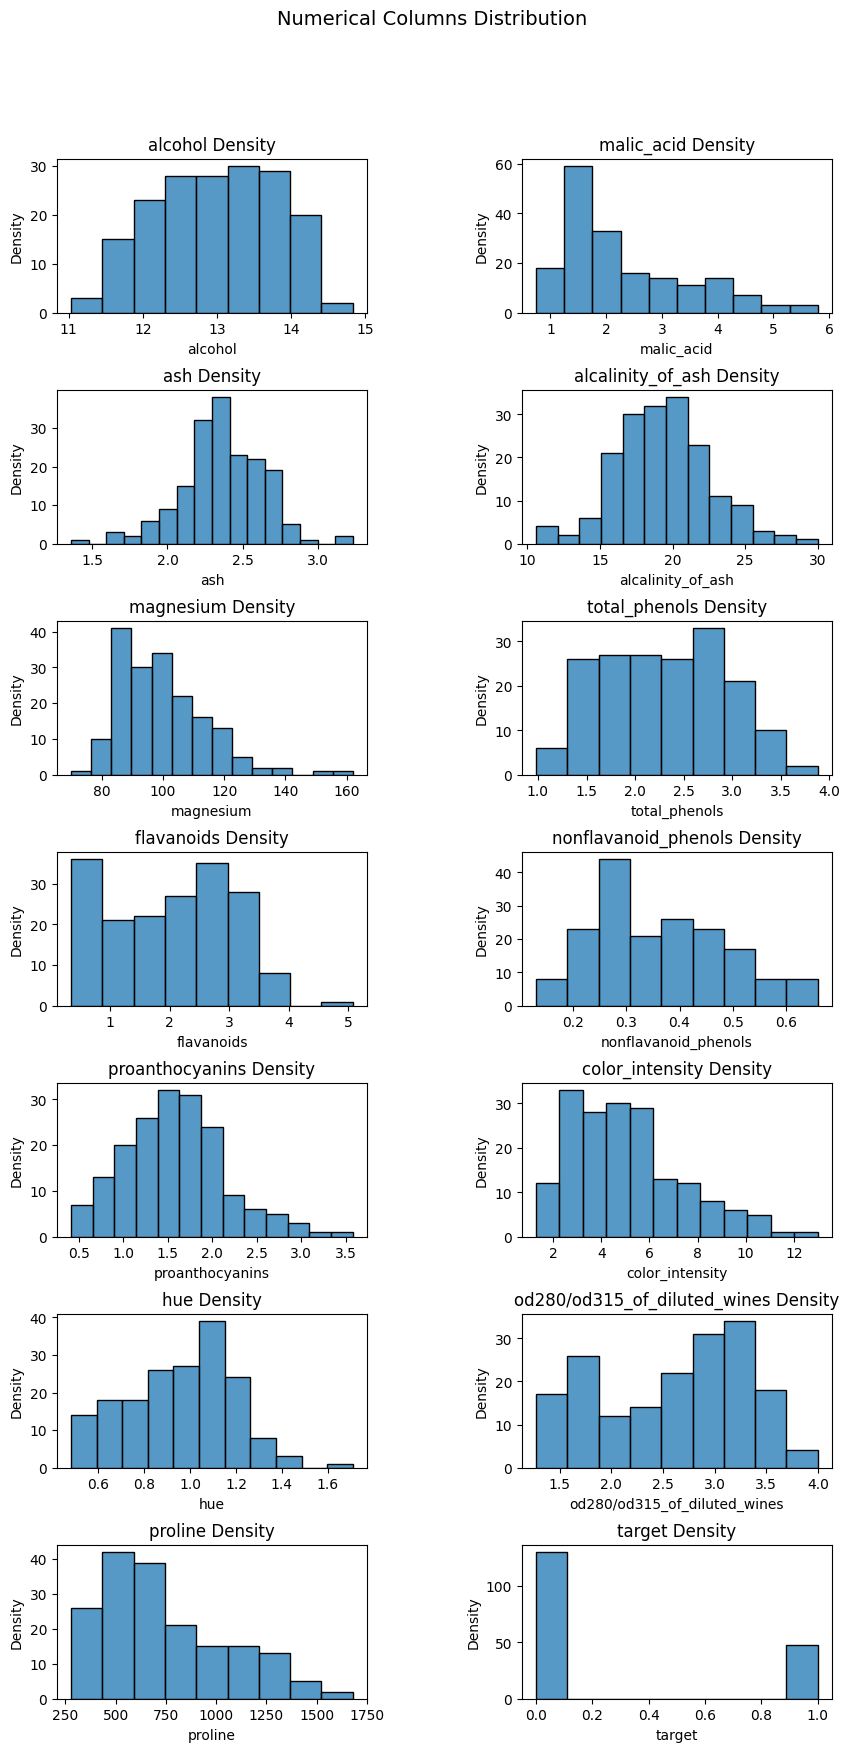

In [5]:
fig, axes = plt.subplots(7, 2, figsize=(10, 20))
for i, col in enumerate(wine_df.columns):
    r,c=i//2,i%2
    sns.histplot(x=col, data=wine_df,ax=axes[r,c])
    axes[i//2,i%2].set_ylabel("Density")
    axes[i//2,i%2].set_title(f"{col} Density")
if len(wine_df) % 2 != 0:
    fig.delaxes(axes[-1, -1])
plt.subplots_adjust(hspace=0.5, wspace=0.5)
fig.text(0.5,0.95,"Numerical Columns Distribution",va="center", ha="center", fontsize=14)
plt.show()

<AxesSubplot: >

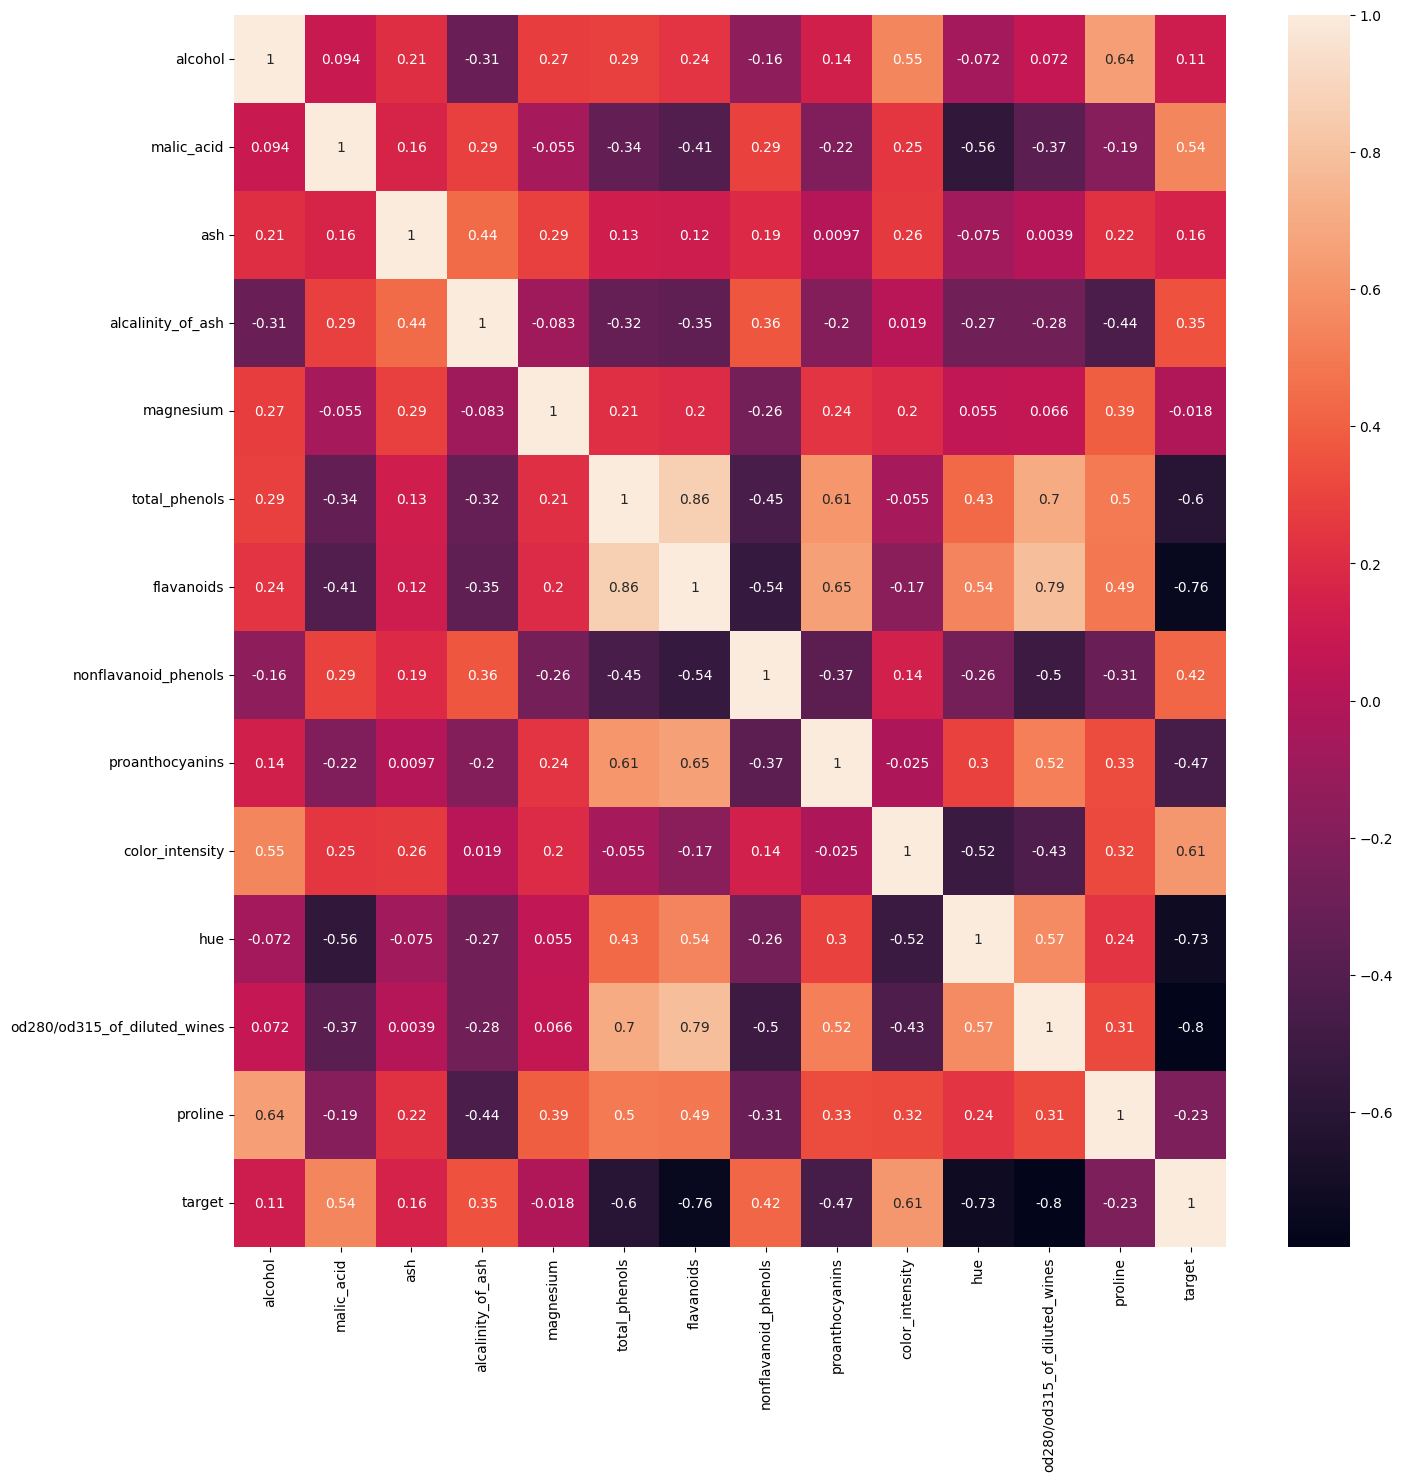

In [6]:
plt.figure(figsize=(16,16))
sns.heatmap(wine_df.corr(numeric_only=True),annot=True)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [8]:
X = wine_df.drop(columns=['target'], axis=1)
y = wine_df['target']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)

In [10]:
scaler = StandardScaler()

ct = ColumnTransformer(
    [
        ("scaling", StandardScaler(), X_train.columns.tolist()),
    ]
)

In [11]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [12]:
from imblearn.over_sampling import SMOTE

In [13]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score

In [16]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier()

In [17]:
y_pred = knn_clf.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))

accuracy_score: 0.9722222222222222
f1_score: 0.9411764705882353
recall_score: 1.0
precision_score: 0.8888888888888888


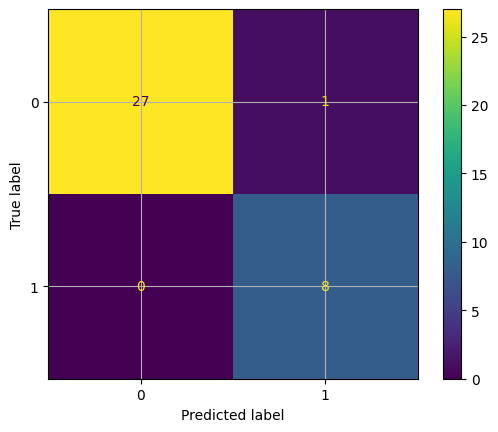

In [18]:
cm = confusion_matrix(y_test, y_pred, labels=knn_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn_clf.classes_)
disp.plot()
plt.grid(visible=None)
plt.show()

In [19]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from imblearn.pipeline import Pipeline

In [25]:
model = Pipeline([
        ('sampling', SMOTE()),
        ('classification', KNeighborsClassifier())
    ])

params_knn = {
    'classification__n_neighbors': [3,5,8,13,15],
    'classification__weights': ['distance'], #['uniform','distance']
    'classification__p': [1] # [1,5,10,30]
}

grid_knn = GridSearchCV(model, param_grid=params_knn, scoring='f1', cv=5,n_jobs=-1)

grid_knn.fit(X_train, y_train)
best_hyperparams = grid_knn.best_params_
print("Best hyperparameters:")
pprint(best_hyperparams)
print("\n")


best_CV_score = grid_knn.best_score_
print("Best 5-fold CV accuracy: {}".format(best_CV_score))

Best hyperparameters:
{'classification__n_neighbors': 5,
 'classification__p': 1,
 'classification__weights': 'distance'}


Best 5-fold CV accuracy: 0.966013071895425


Text(0, 0.5, 'F1 score')

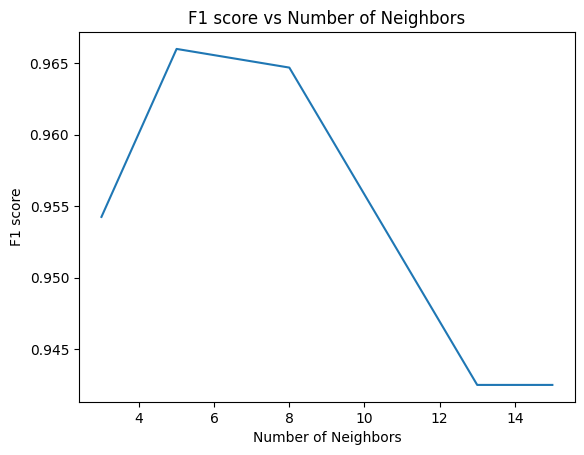

In [27]:
# plt.figure(figsize=(13,13))

results = grid_knn.cv_results_
results_df = pd.DataFrame(results)
scores = results_df['mean_test_score']
results_df

x = [3,5,8,13,15]
plt.plot(x, scores)
plt.title("F1 score vs Number of Neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("F1 score")

In [28]:
y_pred = grid_knn.best_estimator_.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))

accuracy_score: 0.9444444444444444
f1_score: 0.8888888888888888
recall_score: 1.0
precision_score: 0.8


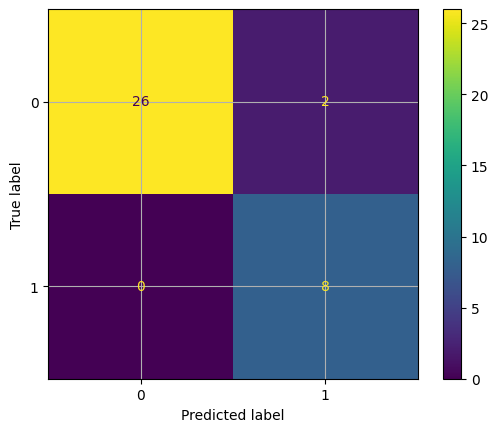

In [29]:
cm = confusion_matrix(y_test, y_pred, labels=knn_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn_clf.classes_)
disp.plot()
plt.grid(visible=None)
plt.show()

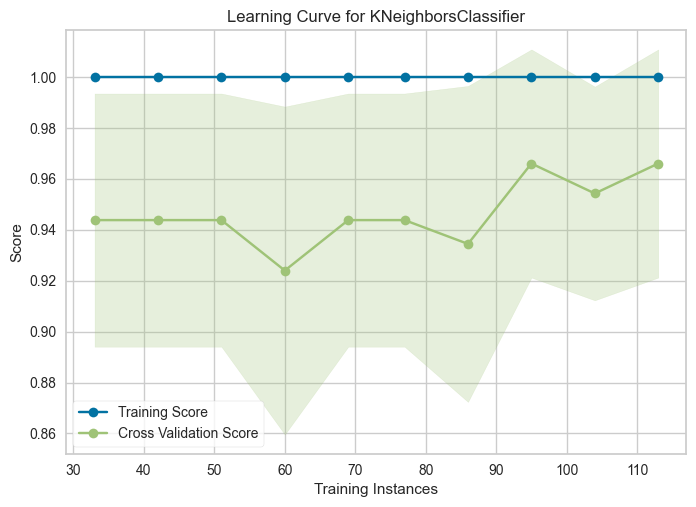

<AxesSubplot: title={'center': 'Learning Curve for KNeighborsClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [33]:
from yellowbrick.model_selection import LearningCurve
sizes = np.linspace(0.3, 1.0, 10)
visualizer = LearningCurve(
    grid_knn.best_estimator_, cv=5, scoring='f1', train_sizes=sizes, n_jobs=-1
)

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show() 

In [34]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train_resampled, y_train_resampled)

SVC()

In [35]:
y_pred = svm_clf.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))

accuracy_score: 1.0
f1_score: 1.0
recall_score: 1.0
precision_score: 1.0


In [37]:
svc_model = Pipeline([
        ('sampling', SMOTE()),
        ('classification', SVC())
    ])

params_svc = {
    'classification__C': [1,3,5],
    'classification__kernel': ['rbf'], #['linear', 'poly', 'sigmoid', 'rbf'],
    'classification__degree': [1,5,10]
}

# 10-fold stratified cross validation
grid_svm = GridSearchCV(estimator=svc_model, param_grid=params_svc, scoring='f1',cv=5,n_jobs=-1)

grid_svm.fit(X_train,y_train)

best_hyperparams = grid_svm.best_params_
print("Best hyperparameters:")
pprint(best_hyperparams)
print("\n")


best_CV_score = grid_svm.best_score_
print("Best 5-fold CV accuracy: {}".format(best_CV_score))

Best hyperparameters:
{'classification__C': 1,
 'classification__degree': 1,
 'classification__kernel': 'rbf'}


Best 5-fold CV accuracy: 0.9615686274509805


In [38]:
y_pred = grid_svm.best_estimator_.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))

accuracy_score: 1.0
f1_score: 1.0
recall_score: 1.0
precision_score: 1.0


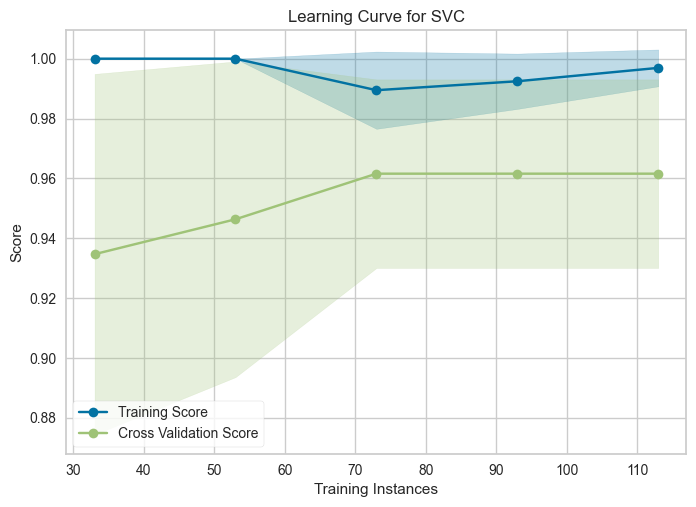

<AxesSubplot: title={'center': 'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [39]:
sizes = np.linspace(0.3, 1.0, 5)
visualizer = LearningCurve(
    grid_svm.best_estimator_, cv=5, scoring='f1', train_sizes=sizes, n_jobs=8
)

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show() 

In [40]:
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing


n_cols = X_train.shape[1]
model = keras.models.Sequential()
model.add(keras.layers.Dense(10, activation='relu', input_shape=(n_cols,)))
#model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(3, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

2024-06-07 13:32:28.907730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['F1Score'])
history_1 = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - F1Score: 0.4151 - loss: 0.5583 - val_F1Score: 0.3636 - val_loss: 0.4696
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4703 - loss: 0.5813 - val_F1Score: 0.3636 - val_loss: 0.4484
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4553 - loss: 0.5266 - val_F1Score: 0.3636 - val_loss: 0.4276
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4220 - loss: 0.5111 - val_F1Score: 0.3636 - val_loss: 0.4077
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4185 - loss: 0.5132 - val_F1Score: 0.3636 - val_loss: 0.3889
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4234 - loss: 0.4528 - val_F1Score: 0.3636 - val_loss: 0.3713
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4431 - loss: 0.4719 - val_F1Score: 0.3636 - val_loss: 0.3546
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4491 - loss: 0.4547 - val_F1Score: 0.3636 - val_loss: 0.3397
Epoch 9/100
5/5

Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4355 - loss: 0.1051 - val_F1Score: 0.3636 - val_loss: 0.0673
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4249 - loss: 0.0889 - val_F1Score: 0.3636 - val_loss: 0.0643
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4495 - loss: 0.0968 - val_F1Score: 0.3636 - val_loss: 0.0616
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4252 - loss: 0.0863 - val_F1Score: 0.3636 - val_loss: 0.0590
Epoch 57/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4748 - loss: 0.0950 - val_F1Score: 0.3636 - val_loss: 0.0564
Epoch 58/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4214 - loss: 0.0828 - val_F1Score: 0.3636 - val_loss: 0.0540
Epoch 59/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4171 - loss: 0.0683 - val_F1Score: 0.3636 - val_loss: 0.0517
Epoch 60/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4334 - loss: 0.0736 - val_F1Score: 0.3636 - val_loss: 0.0495
Epoch 61

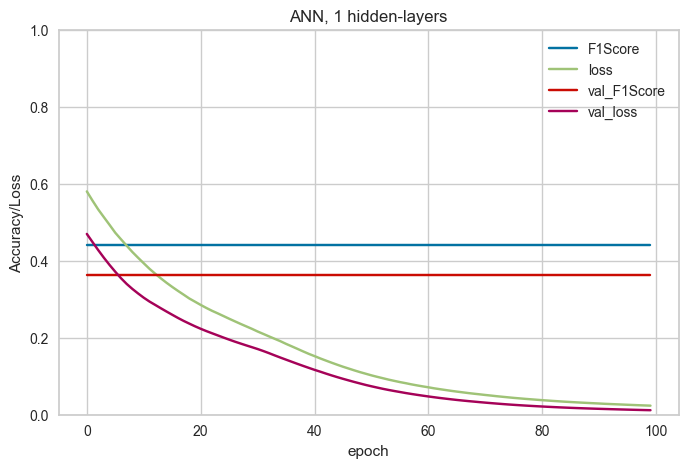

In [44]:
pd.DataFrame(history_1.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("ANN, 1 hidden-layers")
plt.ylabel("Accuracy/Loss")
plt.xlabel("epoch")
plt.show()

In [45]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_trans = le.fit_transform(y_train)
y_test_trans = le.fit_transform(y_test)
opt = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['F1Score'] )
# rand_search_cv = RandomizedSearchCV(model, param_distribs, n_iter=5, cv=3)
history = model.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test))

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - F1Score: 0.4734 - loss: 0.7335 - val_F1Score: 0.3636 - val_loss: 0.6850
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4598 - loss: 0.6594 - val_F1Score: 0.3636 - val_loss: 0.6119
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4365 - loss: 0.5830 - val_F1Score: 0.3636 - val_loss: 0.5474
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4684 - loss: 0.5189 - val_F1Score: 0.3636 - val_loss: 0.4900
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4678 - loss: 0.4517 - val_F1Score: 0.3636 - val_loss: 0.4380
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4720 - loss: 0.4060 - val_F1Score: 0.3636 - val_loss: 0.3920
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4485 - loss: 0.3859 - val_F1Score: 0.3636 - val_loss: 0.3515
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4404 - loss: 0.3373 - val_F1Score: 0.3636 - val_loss: 0.3153
Epoch 9/300
5/5

Epoch 53/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4792 - loss: 0.0155 - val_F1Score: 0.3636 - val_loss: 0.0197
Epoch 54/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4537 - loss: 0.0170 - val_F1Score: 0.3636 - val_loss: 0.0190
Epoch 55/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4046 - loss: 0.0177 - val_F1Score: 0.3636 - val_loss: 0.0184
Epoch 56/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4470 - loss: 0.0187 - val_F1Score: 0.3636 - val_loss: 0.0179
Epoch 57/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4632 - loss: 0.0174 - val_F1Score: 0.3636 - val_loss: 0.0176
Epoch 58/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4500 - loss: 0.0152 - val_F1Score: 0.3636 - val_loss: 0.0173
Epoch 59/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4779 - loss: 0.0128 - val_F1Score: 0.3636 - val_loss: 0.0169
Epoch 60/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4169 - loss: 0.0126 - val_F1Score: 0.3636 - val_loss: 0.0164
Epoch 61

Epoch 105/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4104 - loss: 0.0049 - val_F1Score: 0.3636 - val_loss: 0.0068
Epoch 106/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4337 - loss: 0.0042 - val_F1Score: 0.3636 - val_loss: 0.0067
Epoch 107/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4594 - loss: 0.0047 - val_F1Score: 0.3636 - val_loss: 0.0067
Epoch 108/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4714 - loss: 0.0060 - val_F1Score: 0.3636 - val_loss: 0.0066
Epoch 109/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4076 - loss: 0.0044 - val_F1Score: 0.3636 - val_loss: 0.0065
Epoch 110/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4266 - loss: 0.0042 - val_F1Score: 0.3636 - val_loss: 0.0063
Epoch 111/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4106 - loss: 0.0055 - val_F1Score: 0.3636 - val_loss: 0.0062
Epoch 112/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4485 - loss: 0.0051 - val_F1Score: 0.3636 - val_loss: 0.0061


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.3847 - loss: 0.0019 - val_F1Score: 0.3636 - val_loss: 0.0039
Epoch 157/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4374 - loss: 0.0022 - val_F1Score: 0.3636 - val_loss: 0.0038
Epoch 158/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4594 - loss: 0.0020 - val_F1Score: 0.3636 - val_loss: 0.0039
Epoch 159/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4256 - loss: 0.0025 - val_F1Score: 0.3636 - val_loss: 0.0039
Epoch 160/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4743 - loss: 0.0019 - val_F1Score: 0.3636 - val_loss: 0.0038
Epoch 161/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4088 - loss: 0.0018 - val_F1Score: 0.3636 - val_loss: 0.0037
Epoch 162/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4963 - loss: 0.0017 - val_F1Score: 0.3636 - val_loss: 0.0037
Epoch 163/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4006 - loss: 0.0016 - val_F1Score: 0.3636 - val_loss: 0.0037
Epoch 164/300


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - F1Score: 0.4192 - loss: 0.0011 - val_F1Score: 0.3636 - val_loss: 0.0028
Epoch 208/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4423 - loss: 0.0010 - val_F1Score: 0.3636 - val_loss: 0.0027
Epoch 209/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4371 - loss: 9.6190e-04 - val_F1Score: 0.3636 - val_loss: 0.0027
Epoch 210/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4799 - loss: 0.0011 - val_F1Score: 0.3636 - val_loss: 0.0027
Epoch 211/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4582 - loss: 0.0010 - val_F1Score: 0.3636 - val_loss: 0.0027
Epoch 212/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4454 - loss: 8.2195e-04 - val_F1Score: 0.3636 - val_loss: 0.0027
Epoch 213/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4533 - loss: 0.0012 - val_F1Score: 0.3636 - val_loss: 0.0027
Epoch 214/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4209 - loss: 0.0011 - val_F1Score: 0.3636 - val_loss: 0.0027
Epoch

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.3862 - loss: 5.6341e-04 - val_F1Score: 0.3636 - val_loss: 0.0022
Epoch 258/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4719 - loss: 5.9341e-04 - val_F1Score: 0.3636 - val_loss: 0.0022
Epoch 259/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4442 - loss: 7.8987e-04 - val_F1Score: 0.3636 - val_loss: 0.0022
Epoch 260/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4339 - loss: 6.2070e-04 - val_F1Score: 0.3636 - val_loss: 0.0022
Epoch 261/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4231 - loss: 6.6773e-04 - val_F1Score: 0.3636 - val_loss: 0.0021
Epoch 262/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.4438 - loss: 7.7223e-04 - val_F1Score: 0.3636 - val_loss: 0.0021
Epoch 263/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4355 - loss: 5.3955e-04 - val_F1Score: 0.3636 - val_loss: 0.0021
Epoch 264/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.4205 - loss: 6.6887e-04 - val_F1Score: 0.3636 -

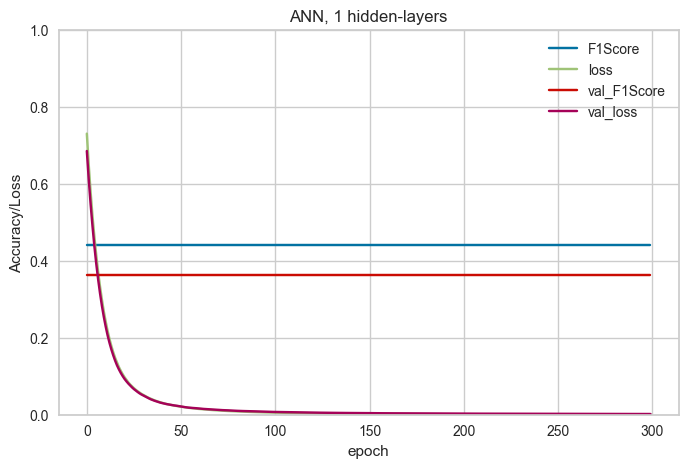

In [46]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("ANN, 1 hidden-layers")
plt.ylabel("Accuracy/Loss")
plt.xlabel("epoch")
plt.show()

In [47]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(300, activation='relu', input_shape=(n_cols,)))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_trans = le.fit_transform(y_train)
y_test_trans = le.fit_transform(y_test)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['F1Score'] )
history_2 = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30


/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - F1Score: 0.4245 - loss: 0.6205 - val_F1Score: 0.3636 - val_loss: 0.2303
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - F1Score: 0.4763 - loss: 0.2066 - val_F1Score: 0.3636 - val_loss: 0.0198
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - F1Score: 0.5026 - loss: 0.0318 - val_F1Score: 0.8000 - val_loss: 2.8099e-04
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - F1Score: 0.8255 - loss: 0.0087 - val_F1Score: 0.9412 - val_loss: 1.1005e-05
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - F1Score: 0.9116 - loss: 5.9896e-05 - val_F1Score: 0.9412 - val_loss: 9.9945e-07
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - F1Score: 0.9552 - loss: 2.8192e-05 - val_F1Score: 0.9412 - val_loss: 1.9040e-07
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - F1Score: 0.9813 - loss: 1.0194e-05 - val_F1Score: 0.9412 - val_loss: 6.8867e-08
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - F1Score: 0.9550 - loss: 8.9332e-06 - val_F1Score: 0.9412 - val_loss

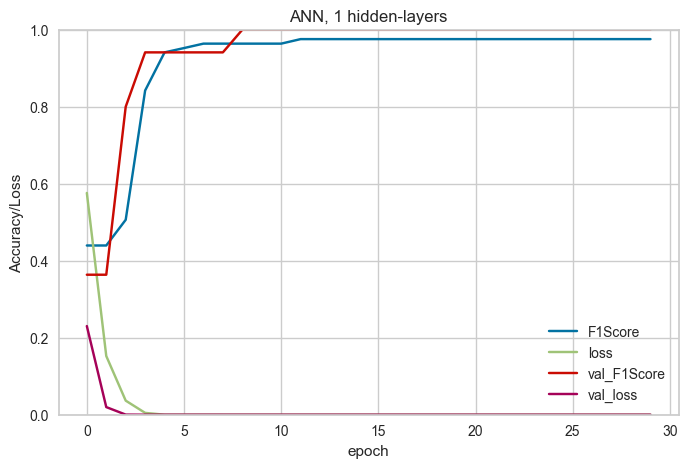

In [48]:
pd.DataFrame(history_2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("ANN, 1 hidden-layers")
plt.ylabel("Accuracy/Loss")
plt.xlabel("epoch")
plt.show()